# SELF DRIVING CAR SIMULATION

**AIM** - To train a model using the images and the values of the car movement that are produced by the simulator. 

## Table of content
- Importing the libraries
- Importing the dataset
- Data Preprocessing
- Model building
- Model training

### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam


## Importing the dataset

In [2]:
### The csv file has no header
### So column header is added.
columns = ['center', 'left', 'right', 'steering', 'throttle','brake', 'speed']
df = pd.read_csv(os.path.join('E:\dev\SelfDrivingCar','driving_log.csv'), names = columns)
df.head()

,center,left,right,steering,throttle,brake,speed
0,E:\dev\SelfDrivingCar\IMG\center_2021_12_28_12...,E:\dev\SelfDrivingCar\IMG\left_2021_12_28_12_5...,E:\dev\SelfDrivingCar\IMG\right_2021_12_28_12_...,0.0,0.0,0,1.358885
1,E:\dev\SelfDrivingCar\IMG\center_2021_12_28_12...,E:\dev\SelfDrivingCar\IMG\left_2021_12_28_12_5...,E:\dev\SelfDrivingCar\IMG\right_2021_12_28_12_...,0.0,0.0,0,1.347272
2,E:\dev\SelfDrivingCar\IMG\center_2021_12_28_12...,E:\dev\SelfDrivingCar\IMG\left_2021_12_28_12_5...,E:\dev\SelfDrivingCar\IMG\right_2021_12_28_12_...,0.0,0.0,0,1.335757
3,E:\dev\SelfDrivingCar\IMG\center_2021_12_28_12...,E:\dev\SelfDrivingCar\IMG\left_2021_12_28_12_5...,E:\dev\SelfDrivingCar\IMG\right_2021_12_28_12_...,0.0,0.0,0,1.327186
4,E:\dev\SelfDrivingCar\IMG\center_2021_12_28_12...,E:\dev\SelfDrivingCar\IMG\left_2021_12_28_12_5...,E:\dev\SelfDrivingCar\IMG\right_2021_12_28_12_...,0.0,0.0,0,1.315843


From the dataset, it is clear that the target variable is the **steering** column. Using the first 3 columns, i.e **center**, **left** and **right** we predict the **steering** values, which will the make the car to remain inside the track.

### Data Preprocessing

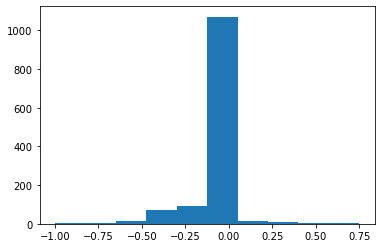

In [3]:
### Visualising the distribution of the steering values.
plt.hist(df.steering)
plt.show()

In [4]:
print("Skewness of the steering feature:\n", df['steering'].skew())

Skewness of the steering feature:
 -1.5489560296509142


The generated steering data is slightly skewed towards left. The reason behind this is may be because the track has more left turns than the right turns. So there are more number of left (-ve) values than right (+ve) values in the steering column.

Let's check the image obtained from the simulator

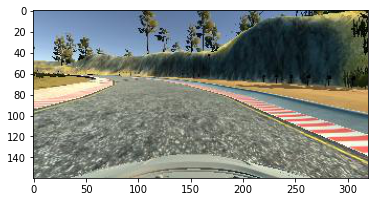

In [5]:
### Checking the image for further operations
img = cv2.imread(df['center'][0])
### convering BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

The image is good, but there are many unnecessary objects like the mountains, trees, sky, etc  that can be removed and only the road track can be considered for the training purpose. Along with that proper color image processing is done using the opencv library.

#### Image Processing

In [6]:
# for normal YUV image output
def image_preprocessing(path):
    # cropping image
    img = cv2.imread(path)
    cropped_img = img[60:160,:]
    # color conversion from BGR to YUV
    final_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2YUV)
    # applycation of gaussian blur
    final_img = cv2.GaussianBlur(final_img,(3,5),0)
    # resize image
    output = cv2.resize(final_img, (300,80))
    # normalizing image
    output = output/255
    return output 


In [7]:
### This function separates the path and file name.
def mod_name(filePath):
    fileName = filePath.split('\\')[-1]
    return fileName


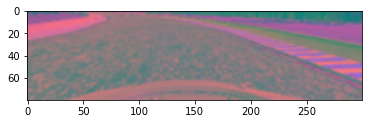

In [11]:
plt.imshow(image_preprocessing(df['center'][0]))

#### Data Augmentation

Creating more training data from the already available ones to obtain good results and prevent overfitting.

In [13]:
### Image and steering measurements augmentation
def data_augmentation(img_process):
    images = []
    steerings = []
    # for each row in the dataset
    for row in range(df.shape[0]):
        # for ith column
        for i in range(3):
            # splitting image path and filename
            fileName = mod_name(df.iloc[row, i])
            filePath = './IMG/'+ fileName
            img = img_process(filePath)
            images.append(img)
            steerings.append(df['steering'][row])
        
    # image and measurement augmentation
    augmented_images, augmented_steerings = [], []
    for image, steering in zip(images, steerings):
        augmented_images.append(image)
        augmented_steerings.append(steering)
        
        # horizontally flippping the images
        flipped_img = cv2.flip(image, 1)
        augmented_images.append(flipped_img)
        # changing the sign to match the flipped images
        augmented_steerings.append(-1*steering)
    
    return augmented_images, augmented_steerings

    
    

0.0


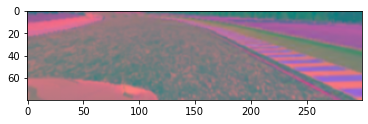

In [44]:
augmented_images, augmented_steerings = data_augmentation(image_preprocessing)
print(augmented_steerings[100])
plt.imshow(augmented_images[100])
plt.show()

### Training and Validation split

In [45]:

X = np.array(augmented_images)
y = np.array(augmented_steerings)

In [46]:
X.shape

(7698, 80, 300, 3)

In [47]:
from sklearn.model_selection import train_test_split
xtrain, xval, ytrain, yval = train_test_split(X, y, test_size = 0.2, random_state = 1)
print('Train images:',len(xtrain))
print('Validation images:',len(xval))


Train images: 6158
Validation images: 1540


In [48]:
xtrain[0].shape

(80, 300, 3)

### Model building and training

This [model](https://www.i-programmer.info/news/105-artificial-intelligence/9678-nvidias-neural-network-drives-a-car.html) architechture is based on the nvidia's neural network for self driving car

In [49]:
model = Sequential()
model.add(Convolution2D(24,(5,5),(2,2),input_shape=xtrain[0].shape))

model.add(Convolution2D(36,(5,5),(2,2),activation='elu'))
model.add(Convolution2D(48,(5,5),(2,2),activation='elu'))
# since the images are very small, we are keeping the stride small and not 2x2.
model.add(Convolution2D(64,(3,3),activation='elu'))
model.add(Convolution2D(64,(3,3),activation='elu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100,activation='elu'))
model.add(Dense(50,activation='elu'))
model.add(Dense(10,activation='elu'))
model.add(Dense(1))

model.compile(Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy'])
print(model.summary())



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 38, 148, 24)       1824      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 17, 72, 36)        21636     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 34, 48)         43248     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 5, 32, 64)         27712     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 3, 30, 64)         36928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 30, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5760)             

In [50]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(xtrain, ytrain, batch_size=128,validation_data=(xval, yval), epochs=100, callbacks=[callback])

Epoch 1/100
49/49 [==============================] - 34s 694ms/step - loss: 0.0404 - accuracy: 0.7660 - val_loss: 0.0182 - val_accuracy: 0.7786
Epoch 2/100
49/49 [==============================] - 29s 592ms/step - loss: 0.0207 - accuracy: 0.7787 - val_loss: 0.0170 - val_accuracy: 0.7786
Epoch 3/100
49/49 [==============================] - 30s 607ms/step - loss: 0.0196 - accuracy: 0.7787 - val_loss: 0.0166 - val_accuracy: 0.7786
Epoch 4/100
49/49 [==============================] - 30s 608ms/step - loss: 0.0188 - accuracy: 0.7787 - val_loss: 0.0162 - val_accuracy: 0.7786
Epoch 5/100
49/49 [==============================] - 29s 594ms/step - loss: 0.0183 - accuracy: 0.7787 - val_loss: 0.0157 - val_accuracy: 0.7786
Epoch 6/100
49/49 [==============================] - 29s 594ms/step - loss: 0.0173 - accuracy: 0.7787 - val_loss: 0.0154 - val_accuracy: 0.7786
Epoch 7/100
49/49 [==============================] - 29s 596ms/step - loss: 0.0172 - accuracy: 0.7787 - val_loss: 0.0154 - val_accuracy:

In [51]:
model.save('model2.h5')

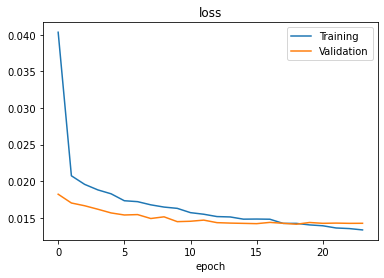

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.show()